In [86]:
#imports the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.stats as stats
import math
import pandas as pd

In [87]:
#creats the parameters which are going to be used for generating the data points
class_means = np.array([[0.0,2.5],[-2.5,-2.0],[2.5,-2.0]])
class_sigmas = np.array([[[3.2,0.0],[0.0,1.2]],[[1.2,0.8],[0.8,1.2]],[[1.2,-0.8],[-0.8,1.2]]])
class_sizes = np.array([120,80,100])

In [88]:
#creates the data points for each class
points1 = np.random.multivariate_normal(class_means[0,:],class_sigmas[0,:,:],class_sizes[0]) 
points2 = np.random.multivariate_normal(class_means[1,:],class_sigmas[1,:,:],class_sizes[1]) 
points3 = np.random.multivariate_normal(class_means[2,:],class_sigmas[2,:,:],class_sizes[2]) 
points = np.concatenate((points1,points2,points3))

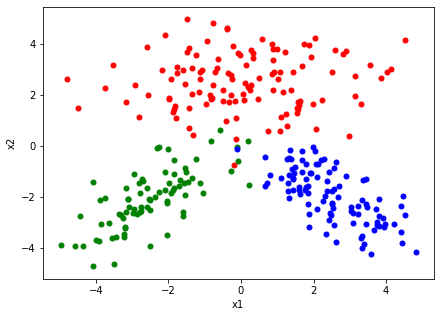

In [89]:
#plots the figure in Q2
plt.figure(figsize=(7,5))
plt.plot(points1[:,0],points1[:,1],"r.",markersize=10)
plt.plot(points2[:,0],points2[:,1],"g.",markersize=10)
plt.plot(points3[:,0],points3[:,1],"b.",markersize=10)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [90]:
#assigns class numbers for each class
y = np.concatenate((np.repeat(1,class_sizes[0]),np.repeat(2,class_sizes[1]),np.repeat(3,class_sizes[2])))

In [91]:
#saves the data points in a .csv file and grabs it under the name of data_set
np.savetxt("hw1_data_set.csv",np.hstack((points,y[:,None])),fmt="%f %f %d")
data_set = np.genfromtxt("hw1_data_set.csv")

In [92]:
#takes the first two column as x and the last column as y, convert the floating numbers in y to integer
x = data_set[:,0:2]
y = data_set[:,2]
y = y.astype(int)

In [93]:
K = np.max(y)

In [94]:
#calculates the sample means, covariances and prior probabilities for each class by using the formulas I have learned in the lecture
sample_means=[[np.mean(x[:,0][y==(c+1)]),np.mean(x[:,1][y==(c+1)])] for c in range(K)]
class_priors = [np.mean(y==(c+1)) for c in range(K)]
sample_covariances = [np.cov(np.transpose(x[y==c+1]),bias=True) for c in range(K)]

In [95]:
print(sample_means)

[[0.055077099999999955, 2.5247606916666663], [-2.47544105, -2.051722525], [2.4836940400000005, -1.9372353999999998]]


In [96]:
print(class_priors)

[0.4, 0.26666666666666666, 0.3333333333333333]


In [97]:
print(sample_covariances)

[array([[3.35098936, 0.13584567],
       [0.13584567, 1.22199989]]), array([[1.24373031, 0.92319256],
       [0.92319256, 1.32565163]]), array([[ 1.06288021, -0.73866295],
       [-0.73866295,  1.08902499]])]


In [98]:
#calculates the parameters Wc, wc and wc0 for a quadratic gscore function
Wc =np.array([(-1/2)*np.linalg.inv(sample_covariances[c]) for c in range(K)])
wc =np.array([np.matmul(np.linalg.inv(sample_covariances[c]),sample_means[c]) for c in range(K)])
wc0 =np.array([-0.5*(np.matmul(np.matmul(np.transpose(sample_means[c]),np.linalg.inv(sample_covariances[c])),sample_means[c]))-
        (x.shape[1]/2)*(np.log(2*math.pi))-
      0.5*np.log(np.linalg.det(sample_covariances[c]))+
      np.log(class_priors[c]) for c in range(K)])

In [103]:
#calculates the score functions for each class and data point, stores the gscore values of
#each class into a single row and does the same operation for each data point
def gscore_calculator(x):
    scores = []
    for c in range(K):
        score = np.matmul(np.matmul(np.transpose(x),Wc[c]),x)+np.matmul(np.transpose(wc[c]),x)+wc0[c]
        scores.append(score)
    return scores

In [104]:
#stores the gscores of each class and data point into an array
gscore_storer=[]
for i in range(x.shape[0]):
    score = gscore_calculator(x[i])
    gscore_storer.append(score)

In [105]:
#stores the the maximum indices of each row and add 1 to it in order to
#determine which class has higher gscore for each row and thus the
#prediction
y_predictions = np.array([])
for i in range(x.shape[0]):
    max_index = np.where(gscore_storer[i]==np.amax(gscore_storer[i]))
    y_predictions=np.append(y_predictions,max_index[0][0]+1).astype(int)

In [106]:
#calculates the confusion matrix
y_truth = y
confusion_matrix = pd.crosstab(y_predictions,y_truth,rownames=["y_pred"],colnames=["y_truth"])

In [107]:
print(confusion_matrix)



y_truth    1   2   3
y_pred              
1        119   1   0
2          1  77   1
3          0   2  99


In [108]:
x1_interval = np.linspace(-6, +6, 1201)
x2_interval = np.linspace(-6, +6, 1201)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)

In [109]:
#initializes the discrimint value array
discriminant_values = np.zeros((len(x1_interval), len(x2_interval), K))
#creates the decision boundries for each class
for c in range(K):
    discriminant_values[:,:,c] =Wc[c][0][0]*x1_grid**2+ Wc[c][1][0]*x1_grid*x2_grid+Wc[c][0][1]*x1_grid*x2_grid + Wc[c][1][1]*x2_grid**2+ wc[c][0] * x1_grid + wc[c][1] * x2_grid + wc0[c]
    
class_red = discriminant_values[:,:,0]
class_green = discriminant_values[:,:,1]
class_blue = discriminant_values[:,:,2]

class_red[(class_red < class_green) & (class_red < class_blue)] = np.nan
class_green[(class_green < class_red) & (class_green < class_blue)] = np.nan
class_blue[(class_blue < class_red) & (class_blue < class_green)] = np.nan


<ipython-input-109-f604061beaa7>:12: RuntimeWarning: invalid value encountered in less
  class_green[(class_green < class_red) & (class_green < class_blue)] = np.nan
<ipython-input-109-f604061beaa7>:13: RuntimeWarning: invalid value encountered in less
  class_blue[(class_blue < class_red) & (class_blue < class_green)] = np.nan


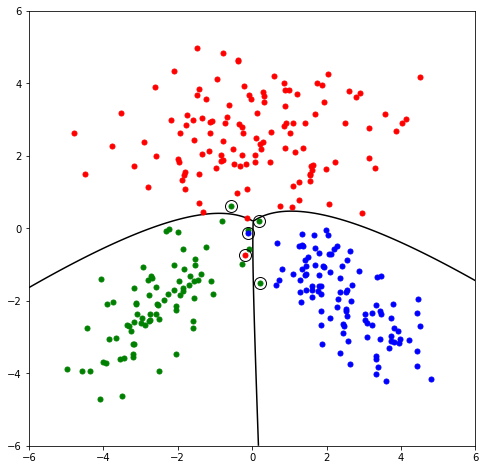

In [110]:
#plots the decision boundries and detects the mispredicted ones
plt.figure(figsize=(8,8))
plt.plot(x[y_truth == 1, 0], x[y_truth == 1, 1], "r.", markersize = 10)
plt.plot(x[y_truth == 2, 0], x[y_truth == 2, 1], "g.", markersize = 10)
plt.plot(x[y_truth == 3, 0], x[y_truth == 3, 1], "b.", markersize = 10)
plt.plot(x[y_predictions != y_truth, 0], x[y_predictions != y_truth, 1], "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, class_red-class_green, levels=0, colors="k")
plt.contour(x1_grid, x2_grid, class_red-class_blue, levels=0, colors="k")
plt.contour(x1_grid, x2_grid, class_green-class_blue, levels=0, colors="k")